*This Jupyter notebook is the official notebook for the MITACS Globalink Research Internship 2022 carried out by Sudeep Gupta under Dr. Hadi Ghofrani at Western University, London, Ontario, Canada. The aim of this notebook is to train a deep learning model which segments dispersion images into background and dispersion energy using image segmentation models.*




---



**Instructions to run the Notebook:**

For the best performance, the notebook should be run with GPU as hardware accelerator and the High-RAM option in runtime shape. These options can be achieved only if you have access to Google Colab Pro version or higher (assuming that it is being run on Google Colab).



Ensure that the selected runtime is GPU by running the following command.



*   If GPU is selected, the output will be: /device:GPU:0
*   If there is no GPU, the output will be: '     ' 



In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

**Import the required libaries**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

from skimage.morphology import medial_axis, skeletonize

import os
from tensorflow.keras.optimizers import Adam
import multiprocessing


**Mount your Google Drive which contains the dispersion images dataset for training/testing.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**To ensure that the loading process for images is fast, the best practice is to upload a zipped file containing the dataset on the google drive and unzip it to the local runtime every time you run the notebook.**



In [ ]:
!unzip /content/drive/MyDrive/MITACS_22/Training_dataset_with_complex_images.zip -d /content/colab_local_split  > /dev/null.

**Use ImageDataGenerator to read a batch of images directly from the local directory**

In [ ]:
 
seed=24
batch_size= 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a dictionary to specify the image augmentation techniques to be applied on the images and the corresponding masks.


img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,  #Original pixel values are 0 and 255. So rescaling to 0 to 1
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 


In [ ]:

#If You need to resize images then add this to the flow_from_directory parameters 
#target_size=(150, 150), #Or whatever the size is for your network

#Since image augmentation does not work well with dipsersion images, we have not used the dictionary (commented out on the next line)
#image_data_generator = ImageDataGenerator(**img_data_gen_args) # Use Augmentation

image_data_generator = ImageDataGenerator(rescale = 1/255.)
image_generator = image_data_generator.flow_from_directory("/content/colab_local_split/train_sample_val_sample_split_with_complex_images/train_images", 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           color_mode = 'grayscale',
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

#mask_data_generator = ImageDataGenerator(**mask_data_gen_args) 
mask_data_generator = ImageDataGenerator(rescale = 1/255.)
mask_generator = mask_data_generator.flow_from_directory("/content/colab_local_split/train_sample_val_sample_split_with_complex_images/train_masks", 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_data_generator = ImageDataGenerator(rescale = 1/255.)

valid_img_generator = valid_data_generator.flow_from_directory("/content/colab_local_split/train_sample_val_sample_split_with_complex_images/val_images", 
                                                               seed=seed, 
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale', 
                                                               class_mode=None) #Default batch size 32, if not specified here
                                                          
valid_mask_generator = valid_data_generator.flow_from_directory("/content/colab_local_split/train_sample_val_sample_split_with_complex_images/val_masks", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here


train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 20085 images belonging to 1 classes.
Found 20085 images belonging to 1 classes.
Found 2510 images belonging to 1 classes.
Found 2510 images belonging to 1 classes.


**Display the pictures to check if the image loading process is working fine**

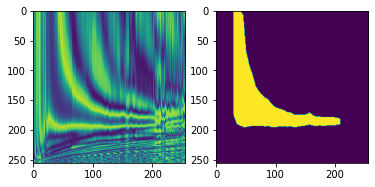

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

**Define the required metrics and losses**

In [ ]:
#####################################################################
#Define the model. Experiment with various loss functions and accuracy metrics
# pip install focal-loss 
#######################################

#Jaccard distance loss mimics IoU. 
from keras import backend as K
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union





!pip install focal-loss
from focal_loss import BinaryFocalLoss



IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Install the Segmentation Models library**

In [ ]:
!pip install segmentation_models
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()
BACKBONE = 'inceptionv3'

preprocess_input = sm.get_preprocessing(BACKBONE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.1 MB/s 
Segmentation Models: using `keras` framework.


**Initialize the U-Net model**

In [ ]:
from segmentation_models import Unet

# define number of channels
#N = X_train.shape[-1]

# define model
model = Unet(backbone_name='inceptionv3', encoder_weights=None, input_shape=(None, None, 1))
#model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.compile('Adam', loss=sm.losses.BinaryFocalLoss(gamma=2.0), metrics=[dice_metric])




**Training Cell**

In [ ]:
num_train_imgs = len(os.listdir('/content/colab_local_split/train_sample_val_sample_split_with_complex_images/train_images/gt_image'))

steps_per_epoch = num_train_imgs //batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
                                            baseline=None, restore_best_weights=False)

loadpath = '/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/Sm_model_full_training_data_6.hdf5';

savepath = '/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/Sm_model_full_training_data_7.hdf5';

chkpoint = tf.keras.callbacks.ModelCheckpoint(savepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch', options=None,
    initial_value_threshold=None)

model.load_weights(loadpath)

history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch=steps_per_epoch,
                    max_queue_size=16, 
                    workers=8,
                    use_multiprocessing=True,
                    verbose = 1,
                    validation_steps=steps_per_epoch, epochs=3, callbacks=[callback, chkpoint])

model.save(savepath)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
627/627 [==============================] - 437s 695ms/step - loss: 0.0031 - dice_metric: 0.8309 - val_loss: 0.0054 - val_dice_metric: 0.8415
Epoch 2/3
627/627 [==============================] - 434s 693ms/step - loss: 0.0031 - dice_metric: 0.8304 - val_loss: 0.0050 - val_dice_metric: 0.8228
Epoch 3/3
627/627 [==============================] - 498s 794ms/step - loss: 0.0029 - dice_metric: 0.8431 - val_loss: 0.0048 - val_dice_metric: 0.8320


**Save the trained model in desired directory**

In [ ]:
model.save('/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/sm_model_full_training_data_unet_with_resnet34.hdf5')

****

**Plot the training and validation accuracy and loss at each epoch**

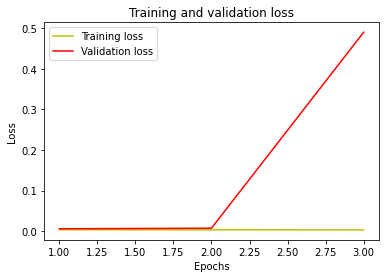

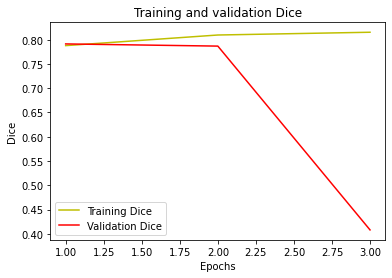

In [ ]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_metric']
#acc = history.history['accuracy']
val_acc = history.history['val_dice_metric']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

**Load a pre-saved model**

In [ ]:
##############################################################
#Test the model on images we held out for testing.
#We can use the generator again for predictions. 
#Remember that this is not test time augmentation. This is only using augmentaton
#to load images from the drive, perfome augmentation and predict. 
# TTA means predicting on augmenting images and then combining predictions for better
#accuracy. 

model = tf.keras.models.load_model("/content/drive/MyDrive/MITACS_22/Notebooks/saved_models/sm_model_full_training_data_unet_with_pretrained_weights_2.hdf5", compile=False)

**Load Images for testing**

In [ ]:

import random
seed = random.randint(0, 100)

test_img_generator = valid_data_generator.flow_from_directory("/content/colab_local_split/train_sample_val_sample_split_with_complex_images/test_images", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              color_mode = 'grayscale',
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = valid_data_generator.flow_from_directory("/content/colab_local_split/train_sample_val_sample_split_with_complex_images/test_masks", 
                                                              seed=seed, 
                                                              batch_size=32, 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here

a = test_img_generator.next()
b = test_mask_generator.next()

### Testing on a few test images
"""
for i in range(0,5):
    image = a[i]
    mask = b[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

"""

Found 2512 images belonging to 1 classes.
Found 2512 images belonging to 1 classes.


"\nfor i in range(0,5):\n    image = a[i]\n    mask = b[i]\n    plt.subplot(1,2,1)\n    plt.imshow(image[:,:,0], cmap='gray')\n    plt.subplot(1,2,2)\n    plt.imshow(mask[:,:,0])\n    plt.show()\n\n"

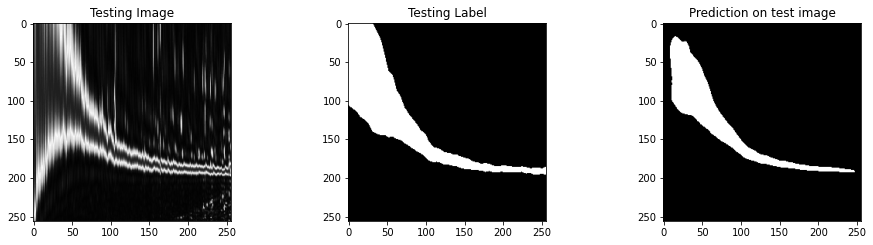

In [ ]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

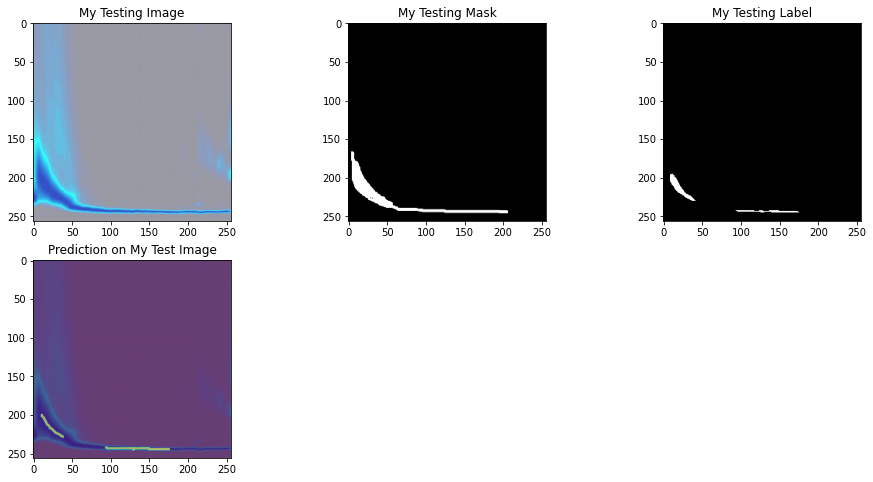

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
img_name = 'SUR022_pt5m.jpg' #18010

#load the image
my_image = load_img('/content/colab_local_split/train_sample_val_sample_split_with_complex_images/test_images/gt_image/' + img_name ,color_mode="grayscale", target_size=(256, 256))
my_mask = load_img('/content/colab_local_split/train_sample_val_sample_split_with_complex_images/test_masks/gt_binary_image/'+ img_name,color_mode="grayscale", target_size=(256, 256))
test_img = cv2.imread('/content/colab_local_split/train_sample_val_sample_split_with_complex_images/test_images/gt_image/' + img_name)
resized = cv2.resize(test_img, (256,256), interpolation = cv2.INTER_AREA)

#preprocess the image
my_image = img_to_array(my_image)/255
my_image_input=np.expand_dims(my_image, 0)

my_mask = img_to_array(my_mask)

#make the prediction
my_prediction = (model.predict(my_image_input)[0,:,:,0] > 0.6).astype(np.uint8)



# Find medial axis
#skeleton = medial_axis(my_prediction).astype(np.uint8)
#skeleton = skeletonize(my_prediction)
skeleton = skeletonize(my_prediction, method='lee')
kernel = np.ones((3,3),np.uint8)
skeleton_thick = cv2.dilate(np.float32(skeleton),kernel,iterations = 1)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('My Testing Image')
plt.imshow(resized, cmap='gray')
plt.subplot(232)
plt.title('My Testing Mask')
plt.imshow(my_mask[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('My Testing Label')
plt.imshow(my_prediction, cmap='gray')
plt.subplot(234)
plt.title('Prediction on My Test Image')
plt.imshow(resized)
plt.imshow(skeleton_thick, alpha = 0.6)


plt.show()

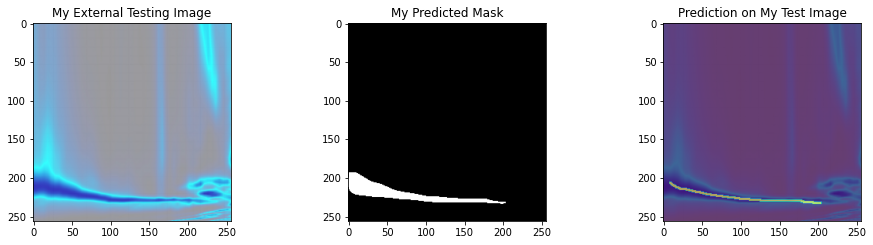

In [ ]:
ext_img_name = '/content/SUR007_fin.jpg'

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
test_image_ext = load_img(ext_img_name,color_mode="grayscale", target_size=(256, 256))
test_image_ext = img_to_array(test_image_ext)/255
test_image_ext_input=np.expand_dims(test_image_ext, 0)

ext_test_img = cv2.imread(ext_img_name)
resized_ext = cv2.resize(ext_test_img, (256,256), interpolation = cv2.INTER_AREA)


test_image_ext_prediction = (model.predict(test_image_ext_input)[0,:,:,0] > 0.6).astype(np.uint8)

skeleton = skeletonize(test_image_ext_prediction, method='lee')
kernel = np.ones((3,3),np.uint8)
skeleton_thick = cv2.dilate(np.float32(skeleton),kernel,iterations = 1)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('My External Testing Image', )
plt.imshow(resized_ext, cmap='gray')
plt.subplot(232)
plt.title('My Predicted Mask')
plt.imshow(test_image_ext_prediction, cmap='gray')
plt.subplot(233)
plt.title('Prediction on My Test Image')
plt.imshow(resized_ext)
plt.imshow(skeleton_thick, alpha = 0.6)

In [ ]:
coords = np.column_stack(np.where(skeleton>0)) # Co-ordinates of the dispersion curve

**Converting the obtained coordinates into frequency-velocity values**

In [ ]:

y_min = 100
y_max = 1200

x_min = 2
x_max = 60


scale_factor_y = ((y_max - y_min)/256)
scale_factor_x = ((x_max - x_min)/256)


vel=1/((np.abs((coords[:,0])-256))*scale_factor_y + y_min)

# If frequency is on logarithmic scale:

#https://stackoverflow.com/questions/19472747/convert-linear-scale-to-logarithmic

x1 = 0
x2 = 256
b = (np.log(x_min/x_max))/(x1-x2)
a = x_min/(np.exp(b*x1))
freq = a*np.exp(b*coords[:,1])                # Uncomment this line if frequency is on logarithmic scale

#freq = coords[:,1] * scale_factor_x + x_min                     # Uncomment this line if frequency is on linear scale

f_v = list(zip(freq,vel))